# Logging In PyTorch Lightning

In [1]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Sequence, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Args:
    -----
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from watermark import watermark

Model: TypeAlias = nn.Module

print(watermark(packages="polars,scikit-learn,torch,lightning", python=True))
print("Torch CUDA available?: ", torch.cuda.is_available())

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

polars      : 0.20.18
scikit-learn: 1.4.1.post1
torch       : 2.2.2
lightning   : 2.2.1

Torch CUDA available?:  False


In [4]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_features: int, num_classes: int) -> None:
        """Multi-layer perceptron (MLP) with two hidden layers."""
        super().__init__()

        self.all_layers = nn.Sequential(
            # 1st hidden layer
            nn.Linear(num_features, 50),
            nn.ReLU(),
            # 2nd hidden layer
            nn.Linear(50, 25),
            nn.ReLU(),
            # Output layer
            nn.Linear(25, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, start_dim=1)
        logits: torch.Tensor = self.all_layers(x)
        return logits


class LightningModel(L.LightningModule):
    """
    A PyTorch Lightning module that wraps a PyTorch model, providing training and validation steps, as well
    as configuring the optimizer.

    The `LightningModel` class takes a PyTorch model and a learning rate as input, and provides the
    following functionality:

        - The `forward` method simply passes the input through the PyTorch model.
        - The `training_step` method computes the loss using cross-entropy loss and logs the training loss.
        - The `validation_step` method computes the loss using cross-entropy loss and logs the validation loss.
        - The `configure_optimizers` method sets up an Adam optimizer with the provided learning rate.

    This class can be used as a building block for more complex PyTorch Lightning models, allowing you to easily integrate your PyTorch models into a PyTorch Lightning pipeline.
    """

    def __init__(self, model: Model, learning_rate: float = 0.001) -> None:
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

        # === NEW! ===
        # Set up attributes for computing test accuracy
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def _shared_step(self, batch: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Fetch the data
        features, true_labels = batch
        # Forward prop
        logits = self(features)
        # Compute loss
        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch: int, batch_idx: int) -> torch.Tensor:
        # === NEW! ===
        # Use the shared step function
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch: int, batch_idx: int) -> None:
        # === NEW! ===
        # Use the shared step function
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    # === NEW! ===
    def test_step(self, batch: int, batch_idx: int) -> None:
        _, true_labels, predicted_labels = self._shared_step(batch)

        self.test_acc(predicted_labels, true_labels)
        self.log("accuracy", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [5]:
class MNISTDataModule(L.LightningDataModule):
    def __init__(
        self, data_dir: str = "../../data/mnist", batch_size: int = 64, seed: int = 42
    ) -> None:
        super().__init__()

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.seed = seed

    def prepare_data(self):
        """Prepare the dataset by downloading the training and test sets from the internet."""
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str) -> None:
        """Define the setup method which is responsible for loading and splitting the dataset."""
        self.mnist_test = datasets.MNIST(
            self.data_dir, transform=transforms.ToTensor(), train=False
        )
        self.mnist_predict = datasets.MNIST(
            self.data_dir, transform=transforms.ToTensor(), train=False
        )
        mnist_full = datasets.MNIST(self.data_dir, transform=transforms.ToTensor(), train=True)
        self.mnist_train, self.mnist_val = random_split(
            mnist_full,
            [55_000, 5_000],
            generator=torch.Generator().manual_seed(self.seed),
        )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, batch_size=self.batch_size, shuffle=False)

### Logging With TensorBoard

- Install tensorboard logger

```sh
pip install tensorboard
```

- To access the logs, run:

```sh
tensorboard --logdir=<path/to/logs> --bind_all

# e.g.
tensorboard --logdir=logs --bind_all
```

In [6]:
# === NEW ===
# !pip install tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

torch.manual_seed(42)

data_module = MNISTDataModule()
pytorch_model: Model = PyTorchMLP(num_features=784, num_classes=10)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="auto",  # set to "auto" or "gpu" to use GPUs if available
    devices="auto",  # Uses all available GPUs if applicable
    deterministic=True,
    logger=TensorBoardLogger(save_dir="logs/", name="mnist-model"),  # === NEW ===
)

trainer.fit(model=lightning_model, datamodule=data_module)

train_acc = trainer.test(dataloaders=data_module.train_dataloader())[0]["accuracy"]
val_acc = trainer.test(dataloaders=data_module)[0]["accuracy"]
test_acc = trainer.test(dataloaders=data_module)[0]["accuracy"]

print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)


PATH: str = "./lightning.pt"
torch.save(pytorch_model.state_dict(), PATH)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/mnist-model

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at logs/mnist-model/version_0/checkpoints/epoch=9-step=8590.ckpt
Loaded model weights from the checkpoint at logs/mnist-model/version_0/checkpoints/epoch=9-step=8590.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9105246067047119     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/mnist-model/version_0/checkpoints/epoch=9-step=8590.ckpt
Loaded model weights from the checkpoint at logs/mnist-model/version_0/checkpoints/epoch=9-step=8590.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.910099983215332     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/mnist-model/version_0/checkpoints/epoch=9-step=8590.ckpt
Loaded model weights from the checkpoint at logs/mnist-model/version_0/checkpoints/epoch=9-step=8590.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │     0.910099983215332     │
└───────────────────────────┴───────────────────────────┘

Train Acc 91.05% | Val Acc 91.01% | Test Acc 91.01%


## Logging With CSV

In [7]:
# === NEW ===
from lightning.pytorch.loggers import CSVLogger

In [8]:
torch.manual_seed(123)

dm = MNISTDataModule()

pytorch_model = PyTorchMLP(num_features=784, num_classes=10)

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs/", name="my-model"),  # === NEW ===
    deterministic=True,
)

trainer.fit(model=lightning_model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 40.8 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
40.8 K    Trainable params
0         Non-trainable params
40.8 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


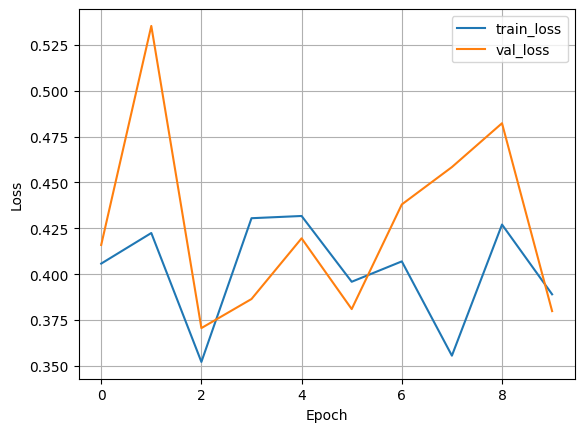

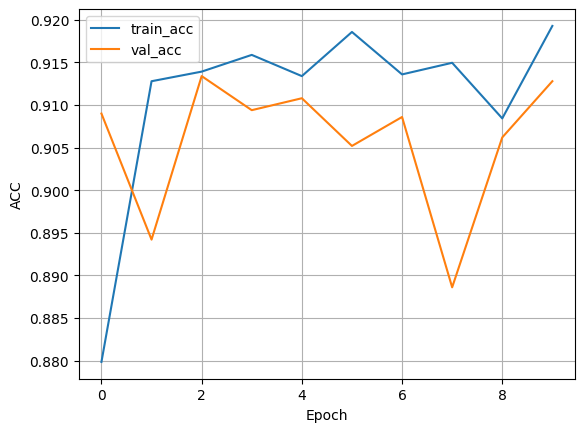

In [9]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

In [10]:
trainer.save_checkpoint("model.ckpt")

## Load Model

In [11]:
pytorch_model = PyTorchMLP(num_features=784, num_classes=10)

lightning_model = LightningModel.load_from_checkpoint(
    checkpoint_path="model.ckpt", model=pytorch_model
)

In [12]:
data_module = MNISTDataModule()
data_module.setup(stage="test")

### Predict On New Data

In [13]:
test_dataloader = data_module.test_dataloader()
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

for batch in test_dataloader:
    # Fetch the data
    features, true_labels = batch

    with torch.inference_mode():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    acc(predicted_labels, true_labels)

predicted_labels[:5]

tensor([1, 2, 8, 4, 5])

In [14]:
test_acc = acc.compute()
print(f"Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Test accuracy: 0.9171 (91.71%)


In [ ]:
a

In [15]:
class_dict: dict[str, str] = {
    0: "digit 0",
    1: "digit 1",
    2: "digit 2",
    3: "digit 3",
    4: "digit 4",
    5: "digit 5",
    6: "digit 6",
    7: "digit 7",
    8: "digit 8",
    9: "digit 9",
}

go_up_from_current_directory(go_up=2)
from src.helper_plotting import show_failures

/Users/neidu/Desktop/Projects/Personal/My_Projects/Deep-Learning-With-Pytorch


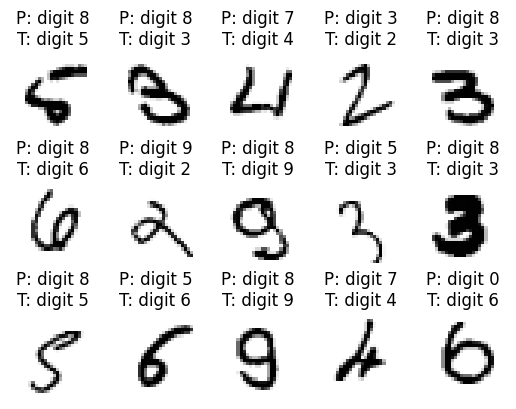

In [16]:
show_failures(model=lightning_model, data_loader=test_dataloader, class_dict=class_dict)

plt.savefig("failures.pdf")

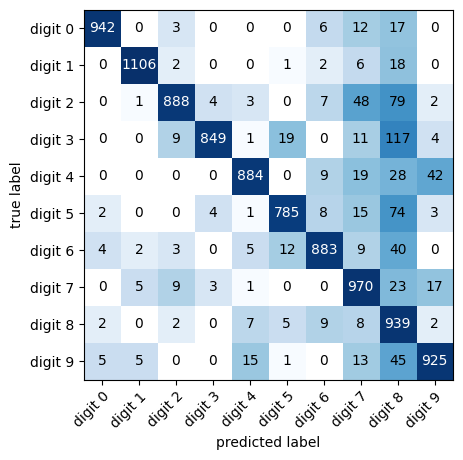

In [18]:
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in dm.test_dataloader():

    with torch.inference_mode():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm(),
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()